# ECE 285 Assignment 1: Classification using Neural Network

Now that you have developed and tested your model on the toy dataset set. It's time to get down and get dirty with a standard dataset such as cifar10. At this point, you will be using the provided training data to tune the hyper-parameters of your network such that it works with cifar10 for the task of multi-class classification.

Important: Recall that now we have non-linear decision boundaries, thus we do not need to do one vs all classification. We learn a single non-linear decision boundary instead. Our non-linear boundaries (thanks to relu non-linearity) will take care of differentiating between all the classes

TO SUBMIT: PDF of this notebook with all the required outputs and answers.

In [1]:
# Prepare Packages
import numpy as np
import matplotlib.pyplot as plt

from ece285.utils.data_processing import get_cifar10_data
from ece285.utils.evaluation import get_classification_accuracy


%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Use a subset of CIFAR10 for the assignment
dataset = get_cifar10_data(
    subset_train=5000,
    subset_val=250,
    subset_test=500,
)

print(dataset.keys())
print("Training Set Data  Shape: ", dataset["x_train"].shape)
print("Training Set Label Shape: ", dataset["y_train"].shape)
print("Validation Set Data  Shape: ", dataset["x_val"].shape)
print("Validation Set Label Shape: ", dataset["y_val"].shape)
print("Test Set Data  Shape: ", dataset["x_test"].shape)
print("Test Set Label Shape: ", dataset["y_test"].shape)

dict_keys(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test'])
Training Set Data  Shape:  (5000, 3072)
Training Set Label Shape:  (5000,)
Validation Set Data  Shape:  (250, 3072)
Validation Set Label Shape:  (250,)
Test Set Data  Shape:  (500, 3072)
Test Set Label Shape:  (500,)


In [2]:
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_val = dataset["x_val"]
y_val = dataset["y_val"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]


In [6]:
# Import more utilies and the layers you have implemented
from ece285.layers.sequential import Sequential
from ece285.layers.linear import Linear
from ece285.layers.relu import ReLU
from ece285.layers.softmax import Softmax
from ece285.layers.loss_func import CrossEntropyLoss
from ece285.utils.optimizer import SGD
from ece285.utils.dataset import DataLoader
from ece285.utils.trainer import Trainer


## Visualize some examples from the dataset.

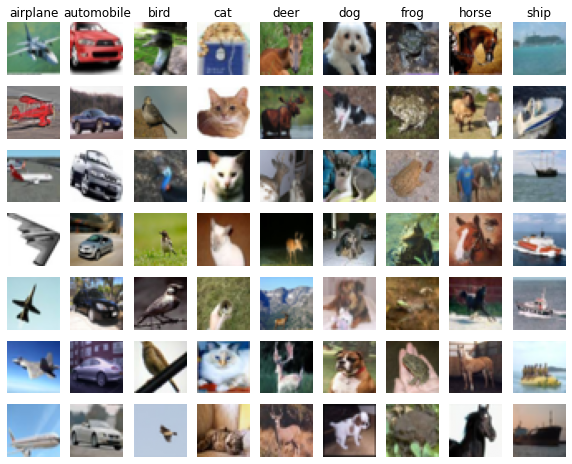

In [4]:
# We show a few examples of training images from each class.
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
]
samples_per_class = 7


def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(dataset[idx])
            plt.axis("off")
            if i == 0:
                plt.title(cls)
    plt.show()


# Visualize the first 10 classes
visualize_data(
    x_train.reshape(5000, 3, 32, 32).transpose(0, 2, 3, 1),
    classes,
    samples_per_class,
)


## Initialize the model

In [5]:
input_size = 3072
hidden_size = 100  # Hidden layer size (Hyper-parameter)
num_classes = 10  # Output

# For a default setting we use the same model we used for the toy dataset.
# This tells you the power of a 2 layered Neural Network. Recall the Universal Approximation Theorem.
# A 2 layer neural network with non-linearities can approximate any function, given large enough hidden layer
def init_model():
    # np.random.seed(0) # No need to fix the seed here
    l1 = Linear(input_size, hidden_size)
    l2 = Linear(hidden_size, num_classes)

    r1 = ReLU()
    softmax = Softmax()
    return Sequential([l1, r1, l2, softmax])


In [7]:
# Initialize the dataset with the dataloader class
dataset = DataLoader(x_train, y_train, x_val, y_val, x_test, y_test)
net = init_model()
optim = SGD(net, lr=0.01, weight_decay=0.01)
loss_func = CrossEntropyLoss()
epoch = 200  # (Hyper-parameter)
batch_size = 200  # (Reduce the batch size if your computer is unable to handle it)


In [8]:
# Initialize the trainer class by passing the above modules
trainer = Trainer(
    dataset, optim, net, loss_func, epoch, batch_size, validate_interval=3
)


Here I deleted the print line to decrease the output space

In [9]:
# Call the trainer function we have already implemented for you. This trains the model for the given
# hyper-parameters. It follows the same procedure as in the last ipython notebook you used for the toy-dataset
train_error, validation_accuracy = trainer.train()


### Print the training and validation accuracies for the default hyper-parameters provided

In [10]:
from ece285.utils.evaluation import get_classification_accuracy

out_train = net.predict(x_train)
acc = get_classification_accuracy(out_train, y_train)
print("Training acc: ", acc)
out_val = net.predict(x_val)
acc = get_classification_accuracy(out_val, y_val)
print("Validation acc: ", acc)


Training acc:  0.3532
Validation acc:  0.324


### Debug the training
With the default parameters we provided above, you should get a validation accuracy of around ~0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the training loss function and the validation accuracies during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

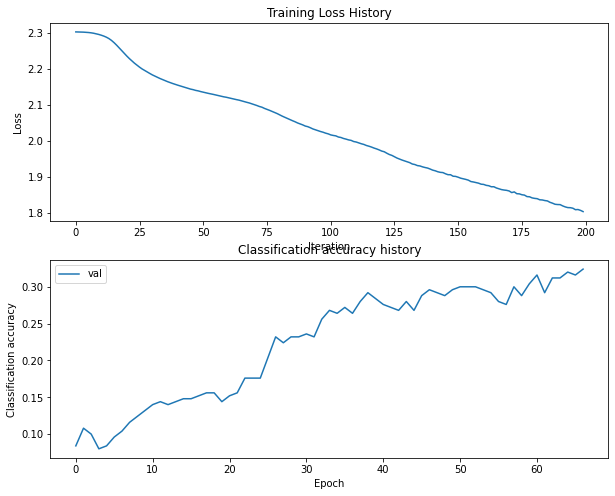

In [11]:
# Plot the training loss function and validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_error)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(2, 1, 2)
# plt.plot(stats['train_acc_history'], label='train')
plt.plot(validation_accuracy, label="val")
plt.title("Classification accuracy history")
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.legend()
plt.show()


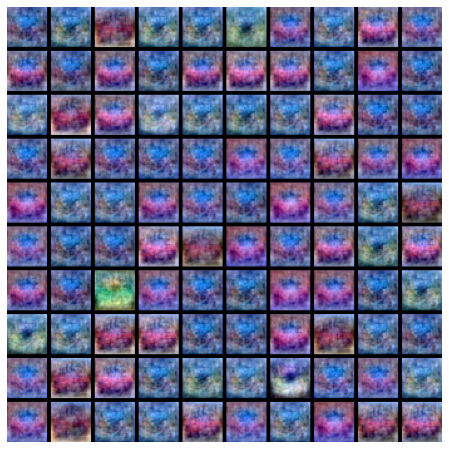

In [12]:
from ece285.utils.vis_utils import visualize_grid

# Credits: http://cs231n.stanford.edu/

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net._modules[0].parameters[0]
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype("uint8"))
    plt.gca().axis("off")
    plt.show()


show_net_weights(net)


# Tune your hyperparameters (50%)

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 40% on the validation set. Our best network gets over 40% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on cifar10 as you can (40% could serve as a reference), with a fully-connected Neural Network.

#### Explain your hyperparameter tuning process below.

#### Your Answer:

In [ ]:
input_size = 3072
hidden_sizes = [150,200,250,300,350]  # Hidden layer size (Hyper-parameter)
num_classes = 10  # Output
epoches = [500]
lrs = [0.01,0.025,0.05,0.1]
weights = [0.0001,0.001,0.01]

def init_model(hidden_size):
    # np.random.seed(0) # No need to fix the seed here
    l1 = Linear(input_size, hidden_size)
    l2 = Linear(hidden_size, num_classes)

    r1 = ReLU()
    softmax = Softmax()
    return Sequential([l1, r1, l2, softmax])
for i in hidden_sizes:
    for j in epoches:
        for l in lrs:
            for w in weights:
                net = init_model(hidden_size=i)
                optim = SGD(net, lr=l, weight_decay=w)
                loss_func = CrossEntropyLoss()
                epoch = j # (Hyper-parameter)
                batch_size = 200  # (Reduce the batch size if your computer is unable to handle it)

                # Initialize the trainer class by passing the above modules
                trainer = Trainer(
                    dataset, optim, net, loss_func, epoch, batch_size, validate_interval=3
                )

                train_error, validation_accuracy = trainer.train()

                out_train = net.predict(x_train)
                acc = get_classification_accuracy(out_train, y_train)
                print('hidden size = {}, epoch = {}, learning rates = {}, weight decay = {}'.format(i,j,l,w))
                print("Training acc: ", acc)
                out_val = net.predict(x_val)
                acc = get_classification_accuracy(out_val, y_val)
                print("Validation acc: ", acc)

                plt.subplot(1, 2, 1)
                plt.plot(train_error)
                plt.title("Training Loss History")
                plt.xlabel("Iteration")
                plt.ylabel("Loss")

                plt.subplot(1, 2, 2)
                # plt.plot(stats['train_acc_history'], label='train')
                plt.plot(validation_accuracy, label="val")
                plt.title("Classification accuracy history")
                plt.xlabel("Epoch")
                plt.ylabel("Classification accuracy")
                plt.legend()
                plt.show()

In [ ]:
best_net_hyperparams = [0.025, 0.01, 500, 200]  # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model hyperparams in best_net.                                                #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# You are now free to test different combinations of hyperparameters to build   #
# various models and test them according to the above plots and visualization   #


# TODO: Show the above plots and visualizations for the default params (already #
# done) and the best hyper-params you obtain. You only need to show this for 2  #
# sets of hyper-params.                                                         #
# You just need to store values for the hyperparameters in best_net_hyperparams #
# as a list in the order
# best_net_hyperparams = [lr, weight_decay, epoch, hidden_size]
#################################################################################

pass


hidden size = 200, epoch = 500, learning rates = 0.01, weight decay = 0.001
Training acc:  0.6098
Validation acc:  0.392


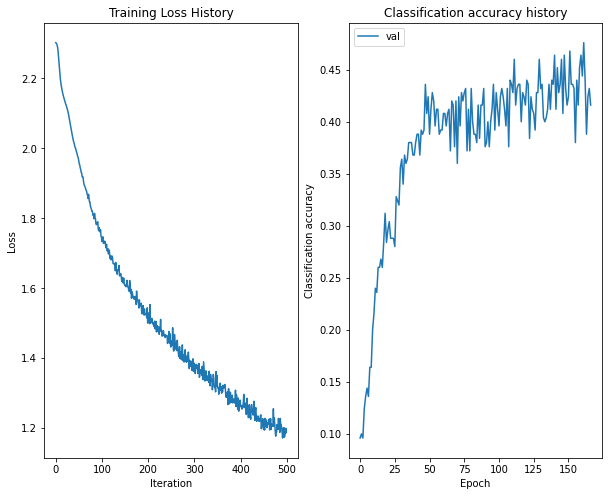

In [24]:
# TODO: Plot the training_error and validation_accuracy of the best network (5%)

best_net = init_model(hidden_size=200)
optim = SGD(best_net, lr=0.025, weight_decay=0.01)
loss_func = CrossEntropyLoss()
epoch = 500 # (Hyper-parameter)
batch_size = 200  # (Reduce the batch size if your computer is unable to handle it)

# Initialize the trainer class by passing the above modules
trainer = Trainer(
    dataset, optim, best_net, loss_func, epoch, batch_size, validate_interval=3
)

train_error, validation_accuracy = trainer.train()

out_train = best_net.predict(x_train)
acc = get_classification_accuracy(out_train, y_train)
print('hidden size = {}, epoch = {}, learning rates = {}, weight decay = {}'.format(i,j,l,w))
print("Training acc: ", acc)
out_val = best_net.predict(x_val)
acc = get_classification_accuracy(out_val, y_val)
print("Validation acc: ", acc)

plt.subplot(1, 2, 1)
plt.plot(train_error)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
# plt.plot(stats['train_acc_history'], label='train')
plt.plot(validation_accuracy, label="val")
plt.title("Classification accuracy history")
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.legend()
plt.show()
# TODO: visualize the weights of the best network (5%)

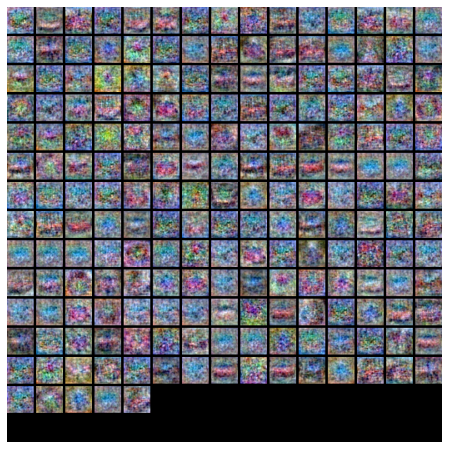

In [25]:
show_net_weights(best_net)

# Run on the test set (30%)
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 35%.

In [26]:
test_acc = (best_net.predict(x_test) == y_test).mean()
print("Test accuracy: ", test_acc)


Test accuracy:  0.42


#### Inline Question (10%)

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

#### Your Answer:

1. Train on a larger dataset
3. Increase the regularization strength

#### Your Explanation:

Testing accuracy being much lower than the training accuracy means overfitting. That's to say, the complexity of the model is too much and the data is not capable of training it. To solve this, the model shall be trained on a larger dataset, and the regularization strength shall be added. 